In [2]:
import os
import cv2
import time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

Running on the GPU
brain_tumor_dataset/no



brain_tumor_dataset/yes



TUMOR: 98
NO TUMOR: 98
Number of data samples:  196


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


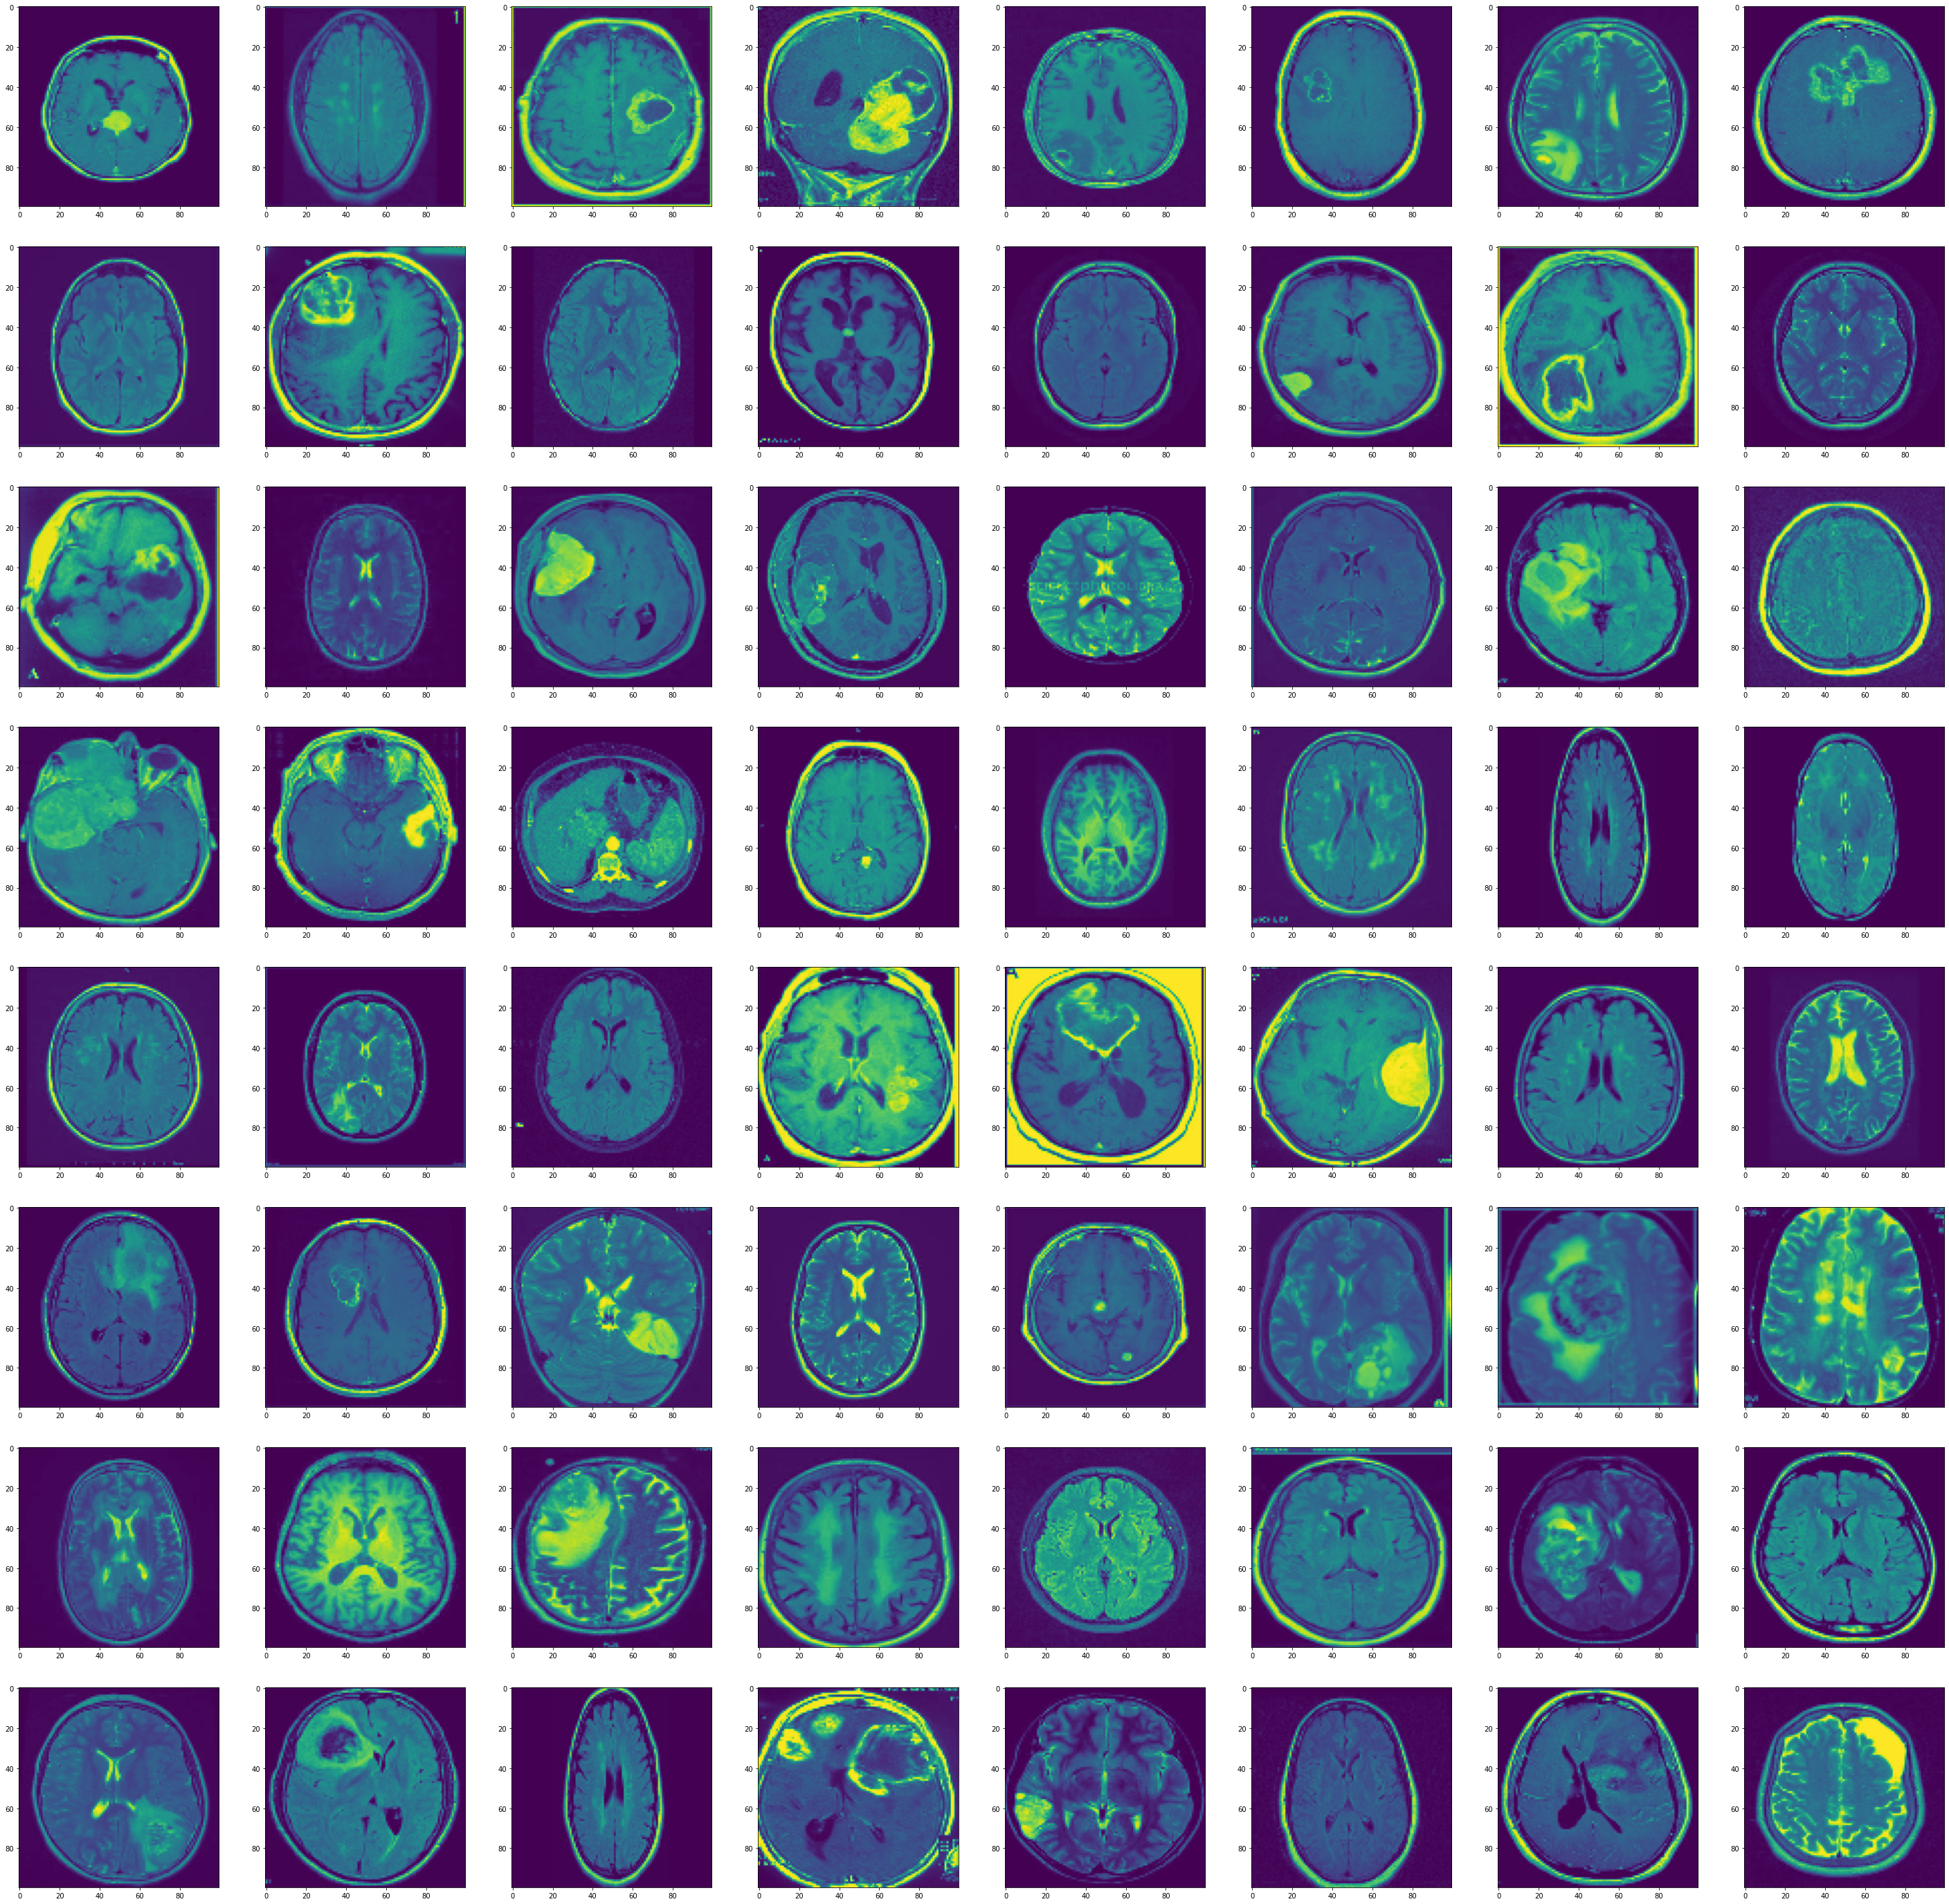

In [3]:
# Set to True to make .npy file with images, only necessary when running for the first time.
REBUILD_DATA = True

# this class reads, converts images to gray scale and resizes to IMG_SIZE
class Make_Data():
    IMG_SIZE = 100
    YES = "brain_tumor_dataset/yes"
    NO = "brain_tumor_dataset/no"
    TESTING = "brain_tumor_dataset/Testing"
    LABELS = {NO: 1, YES: 0}
    converted_data = []

    yes_count = 0
    no_count = 0

    def convert_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" or 'jpeg' or 'png' in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.converted_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) 

                        if label == self.YES:
                            self.yes_count += 1
                        elif label == self.NO:
                            self.no_count += 1
                        
                        # conditional to have balanced classes
                        if self.yes_count == self.no_count:
                            break

                    except Exception as e:
                        pass

        # randomize images
        np.random.shuffle(self.converted_data)
        np.save("data.npy", self.converted_data)
        print('TUMOR:', self.yes_count)
        print('NO TUMOR:', self.no_count)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # this x is axuiliary to handle input dimension for fc1, depending on image size
        x = torch.randn(100, 100).view(-1, 1, 100, 100)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# check for GPU acceleration
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

# whether or not rebuild data
if REBUILD_DATA:
    build_data = Make_Data()
    build_data.convert_data()

converted_data = np.load("data.npy", allow_pickle=True)
print("Number of data samples: ", len(converted_data))

fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(64):
    sub = fig.add_subplot(8, 8, i + 1)
    sub.imshow(converted_data[i,0])

In [4]:
# X and y 
X = torch.Tensor([i[0] for i in converted_data]).view(-1, 100, 100)

# pixel values between zero and one, after X/255
X = X/255.0
y = torch.Tensor([i[1] for i in converted_data])

# percentage for validation dataset
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print("Calculated validation set size: ", val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training samples: ", len(train_X))
print("Test samples: ", len(test_X))

Calculated validation set size:  19
Training samples:  177
Test samples:  19


In [5]:
# first run over a few epochs

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 10
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 100, 100).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
    
train(net)
test(net)


Epoch: 0. Loss: 0.23930813372135162



Epoch: 1. Loss: 0.2418115735054016



Epoch: 2. Loss: 0.2133818417787552



Accuracy: 0.789


In [6]:
# Explore train and test loss/accuracy over epochs

if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Do not rebuild data unless necessary
REBUILD_DATA = False 

if REBUILD_DATA:
    dogsvcats = Make_Data()
    dogsvcats.convert_data()

    converted_data = np.load("data.npy", allow_pickle=True)
    print(len(converted_data))

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    X = torch.Tensor([i[0] for i in converted_data]).view(-1, 100, 100)
    X = X/255.0
    y = torch.Tensor([i[1] for i in converted_data])

    VAL_PCT = 0.1
    val_size = int(len(X)*VAL_PCT)
    print(val_size)

    train_X = X[:-val_size]
    train_y = y[:-val_size]

    test_X = X[-val_size:]
    test_y = y[-val_size:]


def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss


MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def test(size=14):
    rand_start = np.random.randint(len(test_X)-size)
    X, y = test_X[rand_start : rand_start+size], test_y[rand_start : rand_start + size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 100, 100).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size = 10)



def train(net):
    BATCH_SIZE = 10
    EPOCHS = 30

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 100, 100)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i % 1 == 0:
                    val_acc, val_loss = test(size=14)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{epoch},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)



Running on the GPU


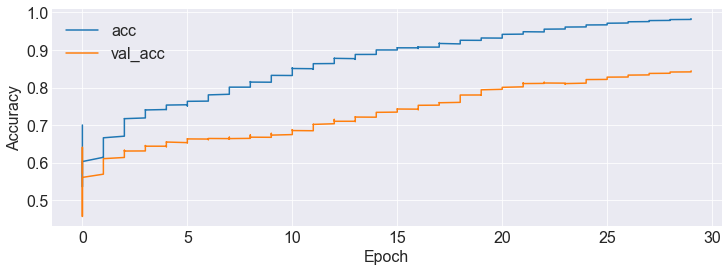

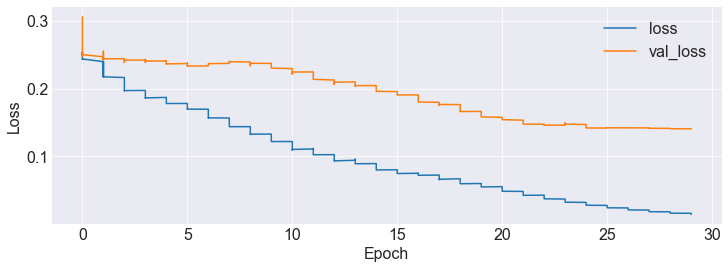

In [7]:
# weighted moving average

def create_acc_loss_graph(model_name):
    plt.rcParams.update({'font.size': 16})
    style.use('seaborn-darkgrid')
    data = pd.read_csv('model.log', names=['model_name', 'timestamp', 'epoch', 'acc', 'loss', 'val_acc', 'val_loss'])
    data = data[data.model_name == MODEL_NAME]
    
    # Convert to weighted moving average
    for row in ['acc', 'loss', 'val_acc', 'val_loss']:
        data[row] = data[row].ewm(alpha=.01).mean()
    # Plot it
    data[['epoch', 'acc', 'val_acc']].plot(x='epoch', figsize=(12,4))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    data[['epoch', 'loss', 'val_loss']].plot(x='epoch', figsize=(12,4))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')


create_acc_loss_graph(MODEL_NAME)

In [8]:
# Best accuracy achieved after 20 epochs

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 10
    EPOCHS = 26
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 100, 100)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 100, 100).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct / total, 3))
    
train(net)
test(net)


Epoch: 0. Loss: 0.3334489166736603



Epoch: 1. Loss: 0.20434148609638214



Epoch: 2. Loss: 0.17857803404331207



Epoch: 3. Loss: 0.17622528970241547



Epoch: 4. Loss: 0.1584385335445404



Epoch: 5. Loss: 0.12415290623903275



Epoch: 6. Loss: 0.15986758470535278



Epoch: 7. Loss: 0.06635274738073349



Epoch: 8. Loss: 0.13103558123111725



Epoch: 9. Loss: 0.060741178691387177



Epoch: 10. Loss: 0.05708315968513489



Epoch: 11. Loss: 0.025952598080039024



Epoch: 12. Loss: 0.005601567216217518



Epoch: 13. Loss: 0.026821183040738106



Epoch: 14. Loss: 0.15199358761310577



Epoch: 15. Loss: 0.0395437628030777



Epoch: 16. Loss: 0.004818739835172892



Epoch: 17. Loss: 0.07512834668159485



Epoch: 18. Loss: 0.0493210107088089



Epoch: 19. Loss: 0.00011838279897347093



Epoch: 20. Loss: 4.8697827878640965e-05



Epoch: 21. Loss: 4.065992834512144e-05



Epoch: 22. Loss: 2.7007476091966964e-05



Epoch: 23. Loss: 4.4938492465007585e-06



Epoch: 24. Loss: 2.4182772904168814e-06



Epoch: 25. Loss: 1.6739207922000787e-06



Accuracy: 0.947


### Final accuracy of 94 %